# Sismique onde P : Inversion avec PyGimli

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.traveltime as tt
from pygimli.viewer.mpl import createColorBar, drawMesh, drawModel, createColorBarOnly
from pygimli.frameworks.resolution import resolutionMatrix

## Lecture et nettoyage des données

In [2]:
data_raw = pg.physics.traveltime.load('data/sgt/data.sgt')
data = data_raw.copy()
print(data)

Data: Sensors: 41 data: 420, nonzero entries: ['g', 's', 't', 'valid']


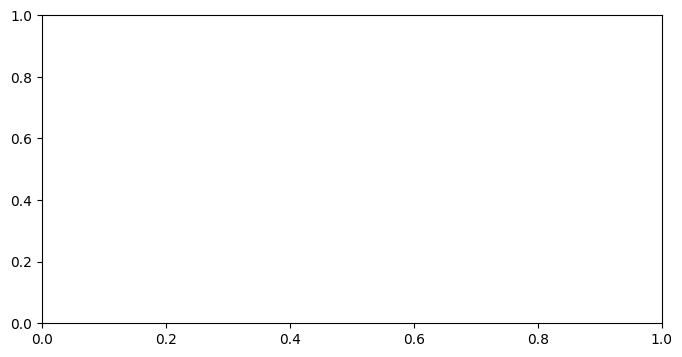

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
lines = tt.drawFirstPicks(ax, data, plotSource = True, 
                          **{'linestyle': '--', 'marker': 'o', 'markersize': '3'})
ax.set_xlabel("Х [m]")
ax.set_ylabel("Temps de trajet [s]")
fig.savefig(f'figures/sismique_s_pointage_brut')

In [4]:
i_shots = np.unique(data['s'])
for k, i_shot in enumerate(i_shots):
    x_shot, y_shot, z_shot = data.sensorPosition(i_shot)
    data_shot = data.copy()
    data_shot.remove(data['s'] != i_shot)
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    tt.show(data_shot, ax=ax, marker='+')
    ax.set_xlabel("Х [m]")
    ax.set_ylabel("Temps de trajet [s]")
    ax.set_xlim(np.min(pg.x(data)), np.max(pg.x(data)))
    ax.set_ylim(0.12, -0.005)
    plt.title(f'Shot à {x_shot:.2f} m')
    plt.savefig(f'figures/pointage/shot_{k:02d}')
    plt.close()

In [5]:
mgr_raw = tt.TravelTimeManager(data_raw)

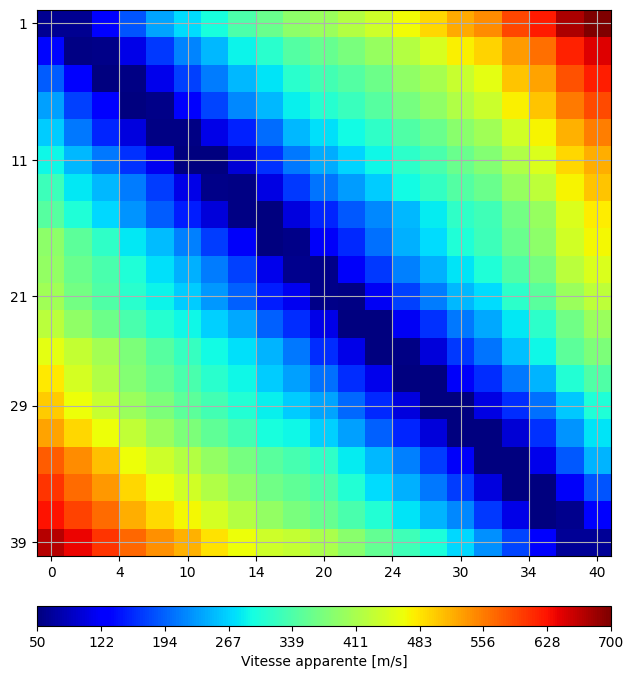

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax, cbar = mgr_raw.showData(ax=ax, logScale=False, nLevs=10, cMap='jet',
                        label = 'Vitesse apparente [m/s]',
                        cMin=50, cMax=700)
fig.savefig(f'figures/sismique_s_vapp_brut')

In [7]:
dmin = 0 # pas besoin, données propres
ii = data['t'] < 0
jj = tt.shotReceiverDistances(data) < dmin
data.remove(ii)
data.remove(jj)
print(f'Retire {sum(ii)} pointés de temps négatifs et {sum(jj)} de géophones trop proches du shot soit {data_raw.size() - data.size()}/{data_raw.size()} données')

Retire 0 pointés de temps négatifs et 0 de géophones trop proches du shot soit 0/420 données


In [8]:
mgr = tt.TravelTimeManager(data)

errLevel = 0.03
data['err'] = mgr.estimateError(data['t'], errLevel=errLevel, absError=1e-9)

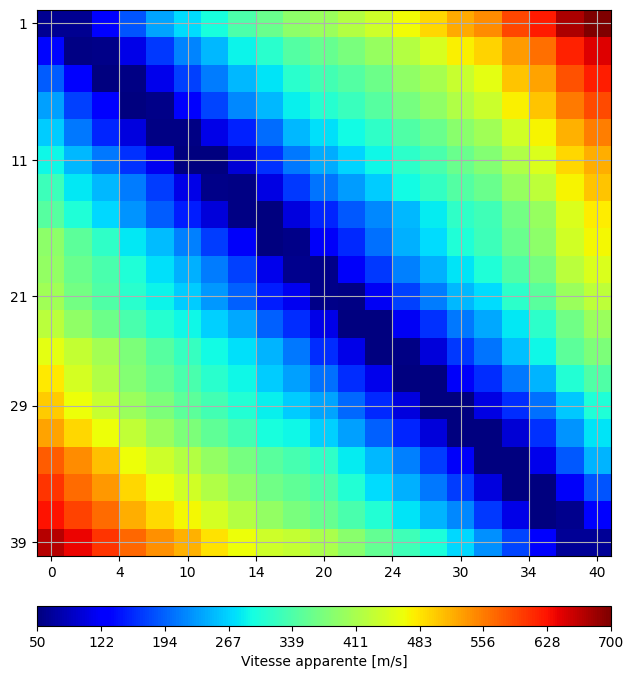

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax, cbar = mgr_raw.showData(ax=ax, logScale=False, nLevs=10, cMap='jet',
                        label = 'Vitesse apparente [m/s]',
                        cMin=50, cMax=700)
fig.savefig(f'figures/sismique_s_vapp')

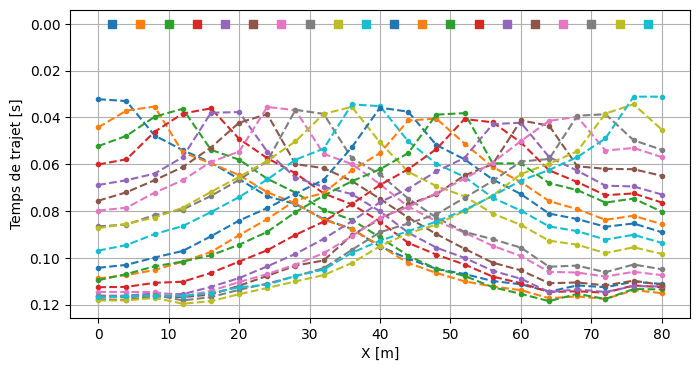

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
lines = tt.drawFirstPicks(ax, data, plotSource = True, 
                          **{'linestyle': '--', 'marker': 'o', 'markersize': '3'})
ax.set_xlabel("Х [m]")
ax.set_ylabel("Temps de trajet [s]")
fig.savefig(f'figures/sismique_s_pointage')

## Inversions préliminaires

In [11]:
mgr.invert()

./core/src/meshentities.cpp:36		GIMLI::Boundary* GIMLI::findBoundary_(const std::set<Boundary*>&)  pls. check, this should not happen.  There is more than one boundary defined.2
Boundary 0x55630bba1370 rtti: 22 id: 0	N: 0 1  marker: 1 
Boundary 0x55630bbdafb0 rtti: 22 id: 82	N: 4 0  marker: -1 
08/12/24 - 19:25:35 - pyGIMLi - INFO - Found 1 regions.
08/12/24 - 19:25:35 - pyGIMLi - INFO - Found 1 regions.
08/12/24 - 19:25:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
08/12/24 - 19:25:35 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.
08/12/24 - 19:25:35 - pyGIMLi - INFO - Create gradient starting model. 500: 5000
08/12/24 - 19:25:35 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.000200/0.002000


605 [122.77772630137888,...,1435.544027670813]

Text(114.15991443116401, 0.5, 'Profondeur [m]')

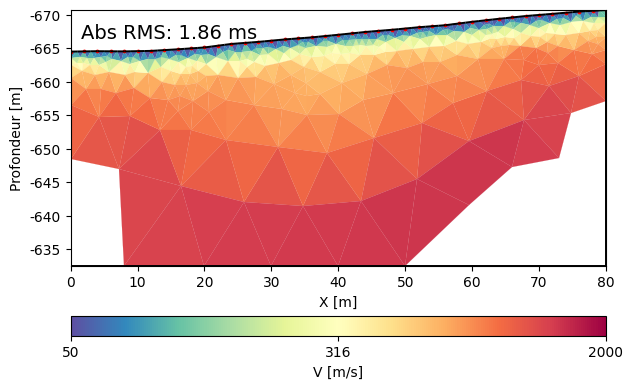

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))

mgr.showResult(ax=ax, logScale=True, nLevs=3, cMap='Spectral_r', colorBar=True, log=False,
               cMin=50, cMax=2000, 
               fitView=True, label='V [m/s]',
               coverage=mgr.standardizedCoverage(),
              )
ax.scatter(data.sensors()[:, 0], data.sensors()[:, 1], s=3, c='r')
ax.text(0.02, 0.95, f'Abs RMS: {mgr.inv.absrms()*1000:.2f} ms', transform=ax.transAxes, fontsize=14, verticalalignment='top')
ax.set_xlabel("Х [m]")
ax.set_ylabel("Profondeur [m]")

(0.065, -0.005)

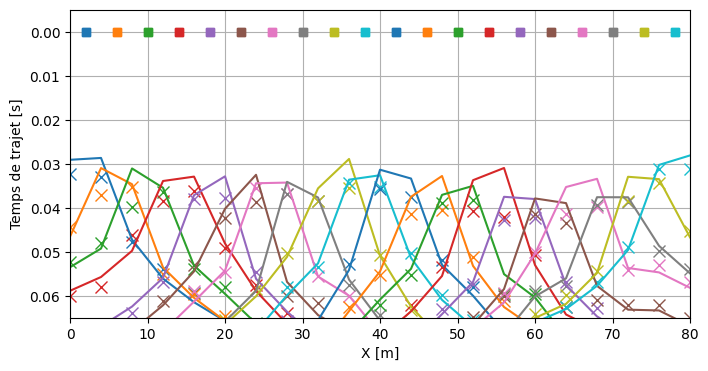

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
mgr.showFit(firstPicks=True, ax=ax)
ax.set_xlabel("Х [m]")
ax.set_ylabel("Temps de trajet [s]")
ax.set_xlim(np.min(pg.x(data)), np.max(pg.x(data)))
ax.set_ylim(0.065, -0.005)

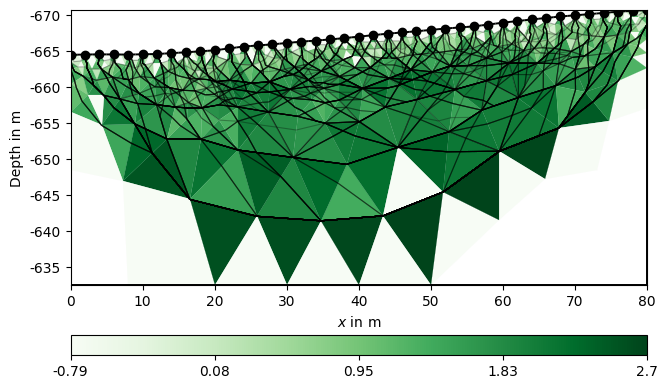

In [14]:
fig, ax = fig, ax = plt.subplots(1, 1, figsize=(8, 4))

sensors = data.sensorPositions()
mgr.showCoverage(ax=ax, cMap="Greens")
mgr.drawRayPaths(ax=ax, color="k", alpha=0.3)
p = ax.plot(sensors[:, 0], sensors[:, 1], "ko")

## Gridsearch des hyperparamètres d'inversion

08/12/24 - 19:25:49 - pyGIMLi - INFO - Create gradient starting model. 10: 500
08/12/24 - 19:25:49 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.002000/0.100000


0 0 0.0 %




08/12/24 - 19:25:55 - pyGIMLi - INFO - Create gradient starting model. 10: 1000
08/12/24 - 19:25:55 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.001000/0.100000


0 1 6.25 %




08/12/24 - 19:26:00 - pyGIMLi - INFO - Create gradient starting model. 10: 2000
08/12/24 - 19:26:00 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.000500/0.100000


0 2 12.5 %




08/12/24 - 19:26:04 - pyGIMLi - INFO - Create gradient starting model. 10: 4000
08/12/24 - 19:26:04 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.000250/0.100000


0 3 18.75 %




08/12/24 - 19:26:10 - pyGIMLi - INFO - Create gradient starting model. 50: 500
08/12/24 - 19:26:10 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.002000/0.020000


1 0 25.0 %




08/12/24 - 19:26:16 - pyGIMLi - INFO - Create gradient starting model. 50: 1000
08/12/24 - 19:26:16 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.001000/0.020000


1 1 31.25 %




08/12/24 - 19:26:21 - pyGIMLi - INFO - Create gradient starting model. 50: 2000
08/12/24 - 19:26:21 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.000500/0.020000


1 2 37.5 %




08/12/24 - 19:26:24 - pyGIMLi - INFO - Create gradient starting model. 50: 4000
08/12/24 - 19:26:24 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.000250/0.020000


1 3 43.75 %




08/12/24 - 19:26:30 - pyGIMLi - INFO - Create gradient starting model. 100: 500
08/12/24 - 19:26:30 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.002000/0.010000


2 0 50.0 %




08/12/24 - 19:26:35 - pyGIMLi - INFO - Create gradient starting model. 100: 1000
08/12/24 - 19:26:35 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.001000/0.010000


2 1 56.25 %




08/12/24 - 19:26:45 - pyGIMLi - INFO - Create gradient starting model. 100: 2000
08/12/24 - 19:26:45 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.000500/0.010000


2 2 62.5 %




08/12/24 - 19:26:51 - pyGIMLi - INFO - Create gradient starting model. 100: 4000
08/12/24 - 19:26:51 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.000250/0.010000


2 3 68.75 %




08/12/24 - 19:26:55 - pyGIMLi - INFO - Create gradient starting model. 200: 500
08/12/24 - 19:26:55 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.002000/0.005000


3 0 75.0 %




08/12/24 - 19:27:04 - pyGIMLi - INFO - Create gradient starting model. 200: 1000
08/12/24 - 19:27:04 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.001000/0.005000


3 1 81.25 %




08/12/24 - 19:27:09 - pyGIMLi - INFO - Create gradient starting model. 200: 2000
08/12/24 - 19:27:09 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.000500/0.005000


3 2 87.5 %




08/12/24 - 19:27:14 - pyGIMLi - INFO - Create gradient starting model. 200: 4000
08/12/24 - 19:27:14 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.000250/0.005000


3 3 93.75 %


10


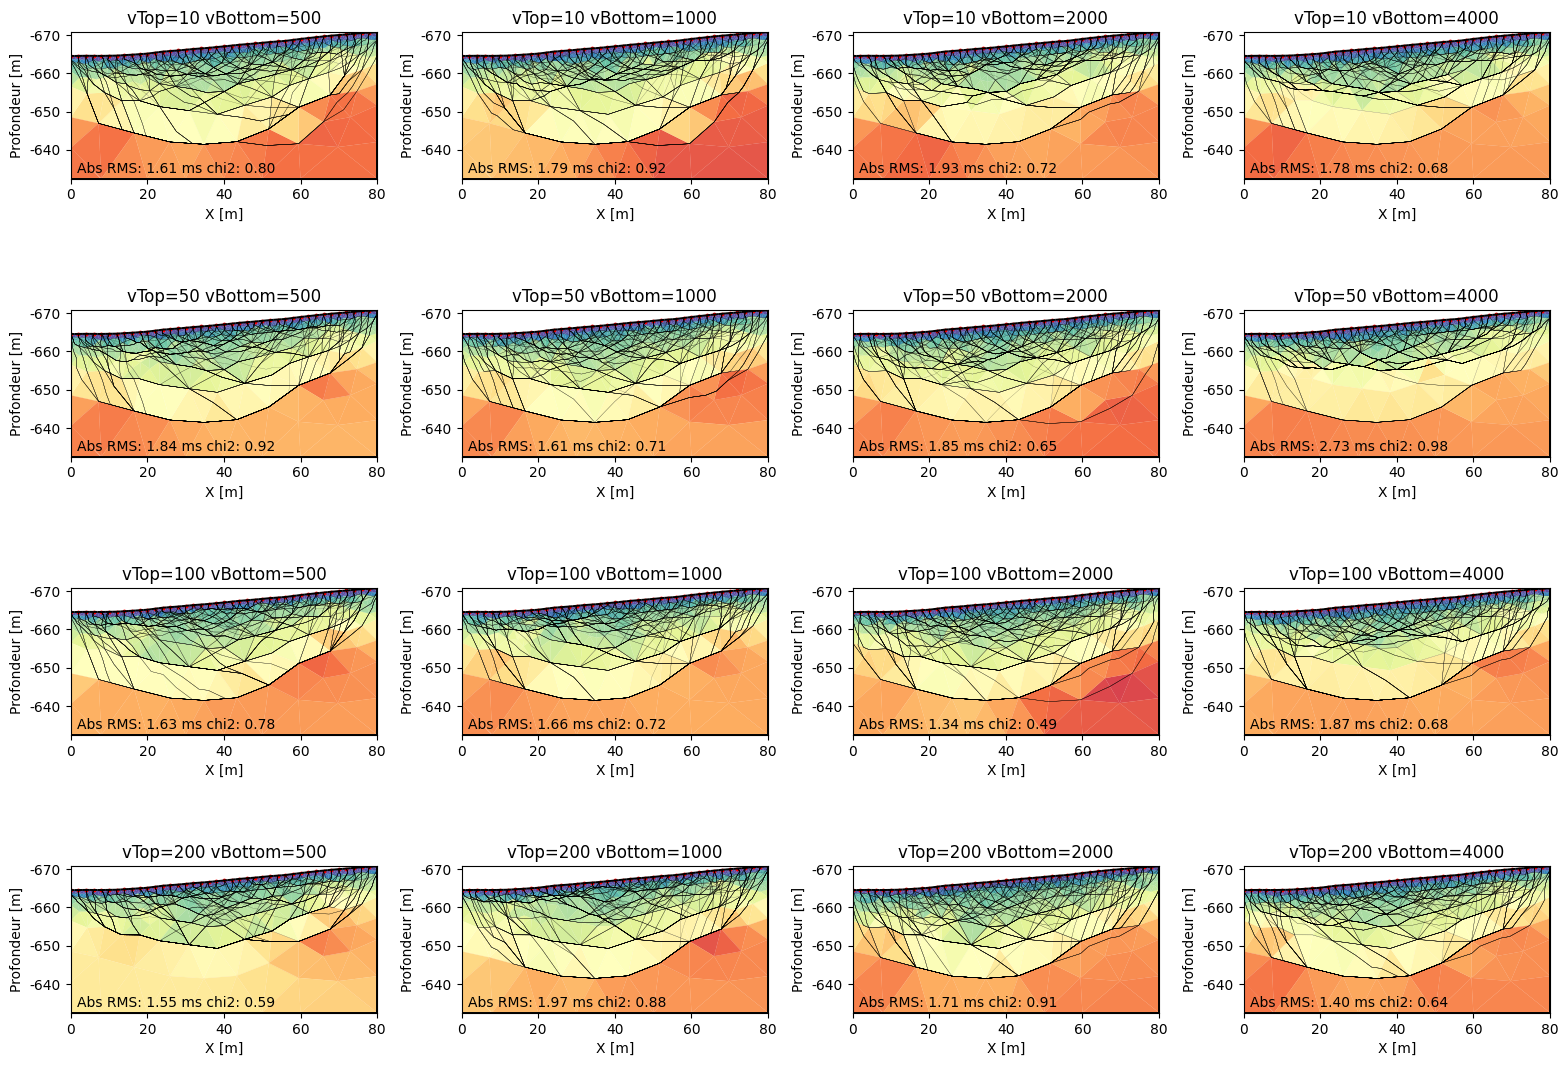

In [15]:
n, m = 4, 4
fig, axs = plt.subplots(n, m, figsize=(16, 14))

abs_rmss = np.zeros((n, m))
chi2s = np.zeros((n, m))

for i, vTop in enumerate([10, 50, 100, 200]):
    for j, vBottom in enumerate([500, 1000, 2000, 4000]):
        print(i, j, (m*i+j)/(n*m)*100, '%')
        
        inv = mgr.invert(secNodes=3, paraMaxCellSize=50.0,
                         zWeight=0.2, vTop=vTop, vBottom=vBottom, verbose=False, usegradient=True, lam=20, dPhi=.1)
        abs_rmss[i, j] = mgr.inv.absrms() 
        chi2s[i, j] = mgr.inv.chi2()
        
        ax = axs[i, j]

        ax, cb = mgr.showResult(ax=ax, logScale=False, nLevs=10, cMap='Spectral_r', colorBar=True, 
                       cMin=50, cMax=2000, orientation='vertical',
                       fitView=True, label='V [m/s]',
                      ) # coverage=mgr.standardizedCoverage(),
        ax.scatter(data.sensors()[:, 0], data.sensors()[:, 1], s=3, c='r')
        ax.text(0.02, 0.02, f'Abs RMS: {mgr.inv.absrms()*1000:.2f} ms chi2: {mgr.inv.chi2():.2f}', transform=ax.transAxes, fontsize=10, verticalalignment='bottom')
        ax.set_xlabel("Х [m]")
        ax.set_ylabel("Profondeur [m]")
        rays = mgr.drawRayPaths(ax=ax, color="k", lw=0.2, alpha=0.5)
        ax.set_title(f'vTop={vTop} vBottom={vBottom}')
        cb.remove()

plt.tight_layout()
fig.savefig(f'figures/sismique_s_variation_modele_vitesse')

print(np.argmin(abs_rmss))

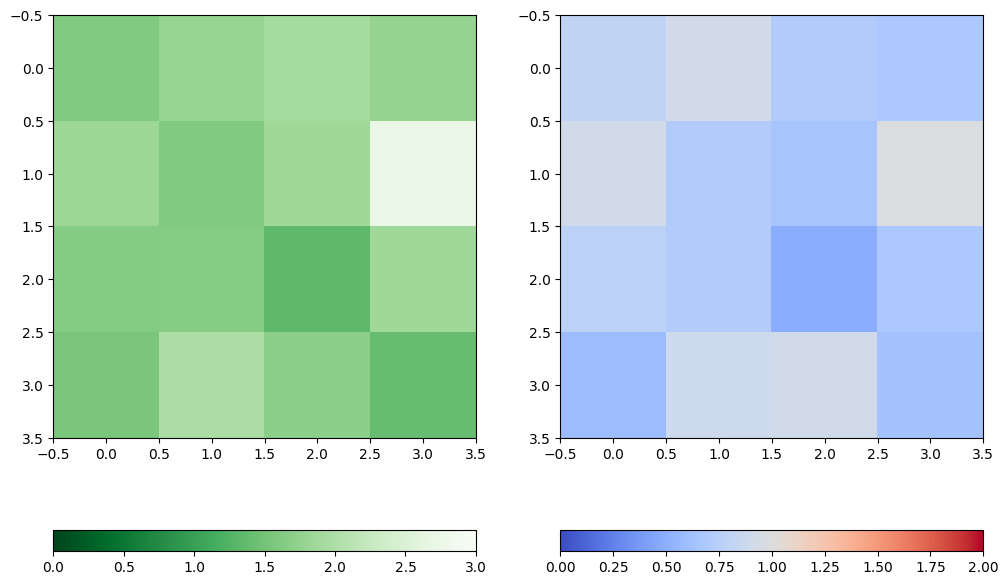

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

ax = axs[0]
im = ax.imshow(abs_rmss*1000, cmap='Greens_r', vmin=0, vmax=3)
fig.colorbar(im, orientation='horizontal')

ax = axs[1]
im = ax.imshow(chi2s, cmap='coolwarm', vmin=0, vmax=2)
fig.colorbar(im, orientation='horizontal')

08/12/24 - 19:27:28 - pyGIMLi - INFO - Create gradient starting model. 10: 2000
08/12/24 - 19:27:28 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.000500/0.100000


0 0




08/12/24 - 19:27:44 - pyGIMLi - INFO - Create gradient starting model. 10: 2000
08/12/24 - 19:27:44 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.000500/0.100000


0 1




08/12/24 - 19:27:52 - pyGIMLi - INFO - Create gradient starting model. 10: 2000
08/12/24 - 19:27:52 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.000500/0.100000


0 2




08/12/24 - 19:27:57 - pyGIMLi - INFO - Create gradient starting model. 10: 2000
08/12/24 - 19:27:57 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.000500/0.100000


0 3




08/12/24 - 19:28:01 - pyGIMLi - INFO - Create gradient starting model. 50: 2000
08/12/24 - 19:28:01 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.000500/0.020000


1 0




08/12/24 - 19:28:15 - pyGIMLi - INFO - Create gradient starting model. 50: 2000
08/12/24 - 19:28:15 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.000500/0.020000


1 1




08/12/24 - 19:28:21 - pyGIMLi - INFO - Create gradient starting model. 50: 2000
08/12/24 - 19:28:21 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.000500/0.020000


1 2




08/12/24 - 19:28:25 - pyGIMLi - INFO - Create gradient starting model. 50: 2000
08/12/24 - 19:28:25 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.000500/0.020000


1 3




08/12/24 - 19:28:28 - pyGIMLi - INFO - Create gradient starting model. 100: 2000
08/12/24 - 19:28:28 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.000500/0.010000


2 0




08/12/24 - 19:28:37 - pyGIMLi - INFO - Create gradient starting model. 100: 2000
08/12/24 - 19:28:37 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.000500/0.010000


2 1




08/12/24 - 19:28:45 - pyGIMLi - INFO - Create gradient starting model. 100: 2000
08/12/24 - 19:28:45 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.000500/0.010000


2 2




08/12/24 - 19:28:51 - pyGIMLi - INFO - Create gradient starting model. 100: 2000
08/12/24 - 19:28:51 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.000500/0.010000


2 3




08/12/24 - 19:28:56 - pyGIMLi - INFO - Create gradient starting model. 200: 2000
08/12/24 - 19:28:56 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.000500/0.005000


3 0




08/12/24 - 19:29:11 - pyGIMLi - INFO - Create gradient starting model. 200: 2000
08/12/24 - 19:29:11 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.000500/0.005000


3 1




08/12/24 - 19:29:20 - pyGIMLi - INFO - Create gradient starting model. 200: 2000
08/12/24 - 19:29:20 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.000500/0.005000


3 2




08/12/24 - 19:29:26 - pyGIMLi - INFO - Create gradient starting model. 200: 2000
08/12/24 - 19:29:26 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.000500/0.005000


3 3




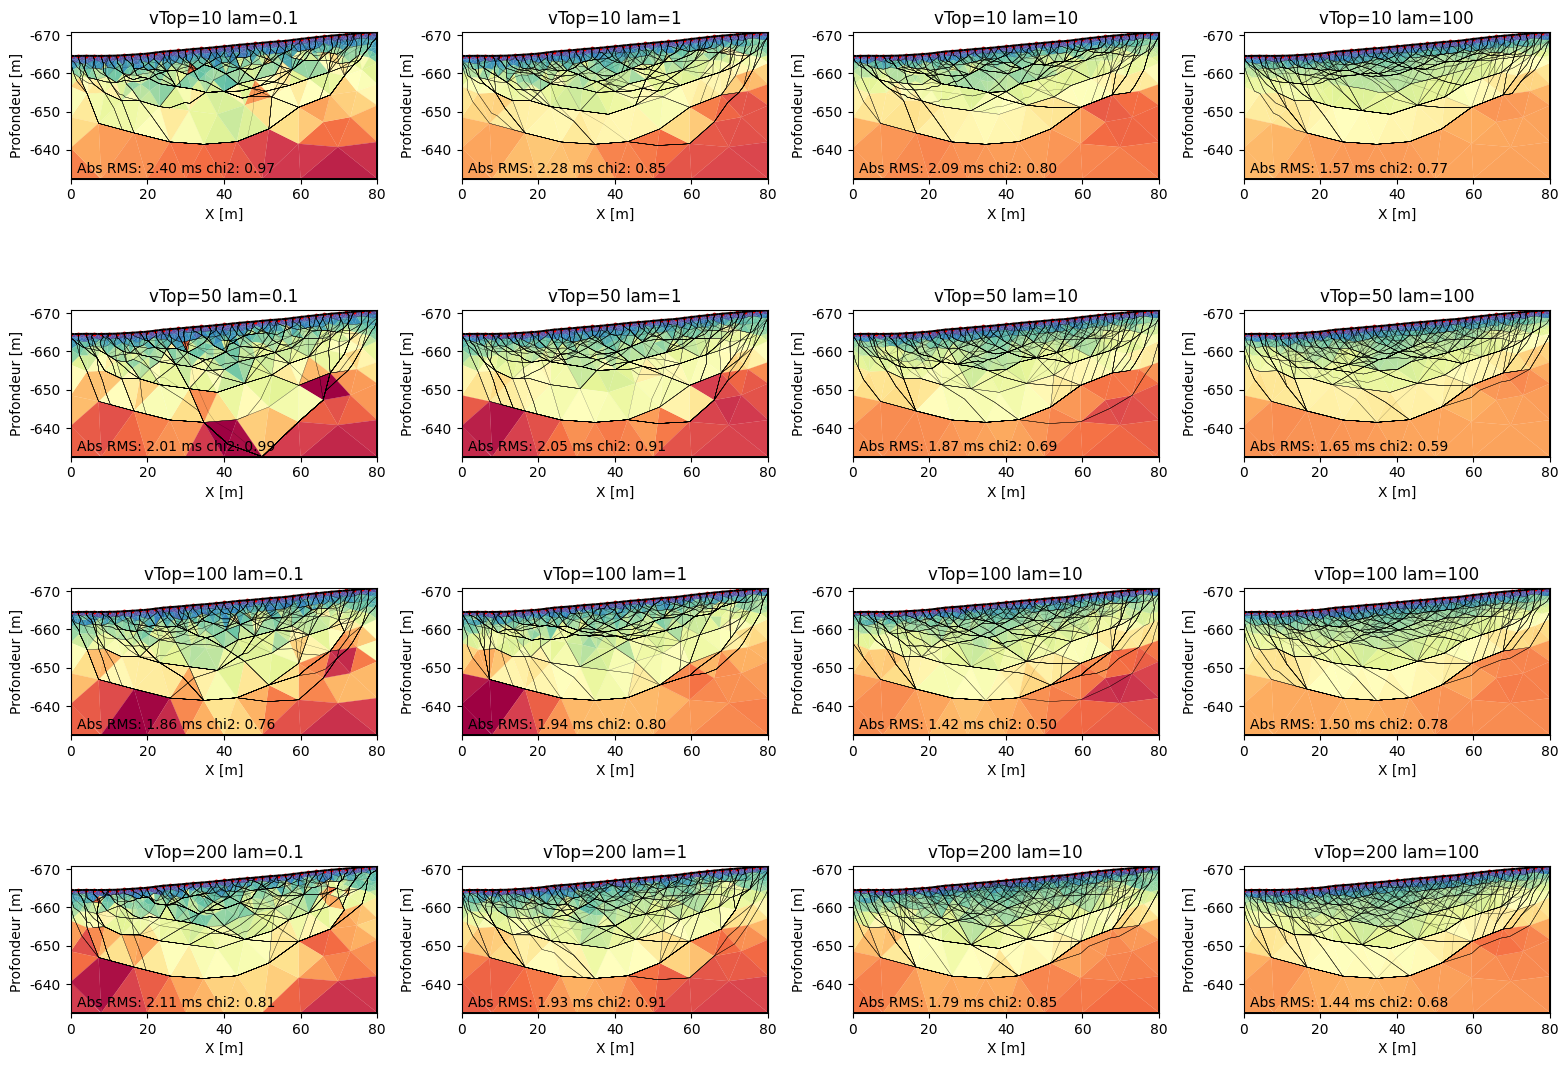

In [17]:
fig, axs = plt.subplots(4, 4, figsize=(16, 14))

abs_rmss = np.zeros((4, 4))
chi2s = np.zeros((4, 4))

for i, vTop in enumerate([10, 50, 100, 200]):
    for j, lam in enumerate([.1, 1, 10, 100]):
        print(i, j)
        
        inv = mgr.invert(secNodes=3, paraMaxCellSize=50.0,
                         zWeight=0.2, vTop=vTop, vBottom=2000, verbose=False, usegradient=True, lam=lam, dPhi=.1)
        abs_rmss[i, j] = mgr.inv.absrms()
        chi2s[i, j] = mgr.inv.chi2()
        ax = axs[i, j]

        ax, cb = mgr.showResult(ax=ax, logScale=False, nLevs=10, cMap='Spectral_r', colorBar=True, 
                       cMin=50, cMax=2000, orientation='vertical',
                       fitView=True, label='V [m/s]') # coverage=mgr.standardizedCoverage(),
        ax.scatter(data.sensors()[:, 0], data.sensors()[:, 1], s=3, c='r')
        ax.text(0.02, 0.02, f'Abs RMS: {mgr.inv.absrms()*1000:.2f} ms chi2: {mgr.inv.chi2():.2f}', transform=ax.transAxes, fontsize=10, verticalalignment='bottom')
        ax.set_xlabel("Х [m]")
        ax.set_ylabel("Profondeur [m]")
        rays = mgr.drawRayPaths(ax=ax, color="k", lw=0.2, alpha=0.5)
        ax.set_title(f'vTop={vTop} lam={lam}')
        cb.remove()

plt.tight_layout()
fig.savefig(f'figures/sismique_s_variation_modele_regularisation')

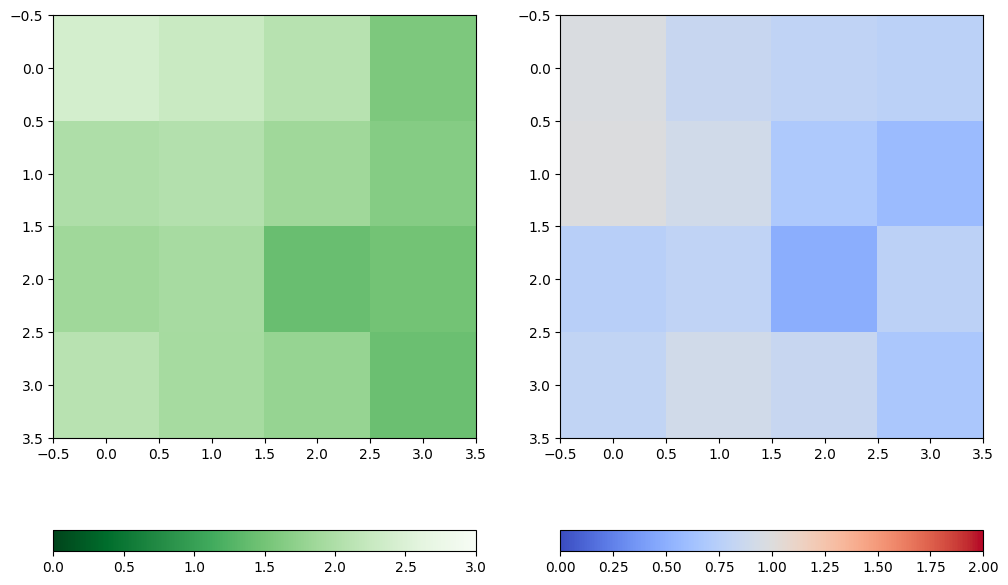

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

ax = axs[0]
im = ax.imshow(abs_rmss*1000, cmap='Greens_r', vmin=0, vmax=3)
fig.colorbar(im, orientation='horizontal')

ax = axs[1]
im = ax.imshow(chi2s, cmap='coolwarm', vmin=0, vmax=2)
fig.colorbar(im, orientation='horizontal')

<Axes: >

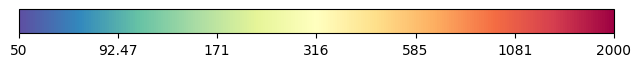

In [19]:
createColorBarOnly(cMin=50, cMax=2000, logScale=True, cMap='Spectral_r', nLevs=7, orientation='horizontal')

## Inversion avec les meilleurs paramètres

In [20]:
inv = mgr.invert(secNodes=3, paraMaxCellSize=50.0, zWeight=0.2, 
                vTop=10, vBottom=500, lam=20, dPhi = .1,
                usegradient=True, verbose=True) # limits=[500, 3000], lambdaFactor = 0.75, dPhi = 2,

08/12/24 - 19:29:40 - pyGIMLi - INFO - Create gradient starting model. 10: 500
08/12/24 - 19:29:40 - pyGIMLi - INFO - Created startmodel from forward operator: 605, min/max=0.002000/0.100000
08/12/24 - 19:29:40 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 278.651/1069.79
fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x7fd17602aa20>
Data transformation: <pgcore._pygimli_.RTrans object at 0x7fd176029710>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x7fd16c313990>
min/max (data): 0.03/0.12
min/max (error): 3%/3%
min/max (start model): 0.002/0.1
--------------------------------------------------------------------------------
use model trans from RegionManager
min/max(dweight) = 278.651/1069.79
 found valid constraints matrix. omit rebuild
constraint matrix of size(nBounds x nModel) 856 x 605
inv.iter 0 ... chi² = 25536.71Calculating Jacobian matrix (forced=1)...... 0.40243 s
min data = 0.0311587 max data = 0.119624 (420)
min error = 0.03 max error = 0.03 (420)
min response = 0.147474 max response = 0.706199 (420)
calc without reference model
0: rms/rrms(data, response) = 0.406224/479.406%
0: chi^2(data, response, error, log) = 25536.7
0: Phi = 1.07254e+

## Visualisation du modèle

In [21]:
vel = mgr.paraModel()
t_data = mgr.data('t').array()
t_model = mgr.inv.response.array()
misfit = t_data - t_model
absrms = mgr.inv.absrms() # np.sqrt(np.mean(misfit**2))
relrms = mgr.inv.relrms() # relative rms, close to np.sqrt(np.sum(misfit**2)/np.sum(t_data**2))*100 TODO what is the exact formula of relrms
chi2 = mgr.inv.chi2() # phi/len(t_data) mean of squared error-weighted misfit
trans = mgr.inv.dataTrans.trans # trans = np.log
trans_error = mgr.inv.dataTrans.error
dData = (trans(t_data) - trans(t_model)) / trans_error(t_data, data['err'])
phi = pg.math.dot(dData, dData) # mgr.inv.phiData() sum of squared error-weighted misfit
phi = mgr.inv.phiData()

i_shots = np.array(mgr.data('s'), dtype=int)
i_shots_unique = np.unique(i_shots)
i_geophones = np.array(mgr.data('g'), dtype=int)
i_geophones_unique = np.unique(i_geophones)
x_offset = pg.physics.traveltime.shotReceiverDistances(data, full=True) # full = correction altitude
x, y, z = data.sensorPositions().array().T

rms_shots = []
for k, i_shot in enumerate(i_shots_unique):
    ii = np.where(i_shot == i_shots)
    rms_shot = np.sqrt(np.mean((t_data[ii] - t_model[ii])**2))
    rms_shots.append(rms_shot)
rms_shots = np.array(rms_shots)

rms_geophones = []
for k, i_geophone in enumerate(i_geophones_unique):
    ii = np.where(i_geophone == i_geophones)
    rms_geophone = np.sqrt(np.mean((t_data[ii] - t_model[ii])**2))
    rms_geophones.append(rms_geophone)
rms_geophones = np.array(rms_geophones)

/home/valentin/micromamba/envs/gimli/lib/python3.11/site-packages/pygimli/frameworks/methodManager.py:897: RuntimeWarning: divide by zero encountered in log10
  return np.log10(covTrans[:nCells] / self.fop.paraDomain.cellSizes())


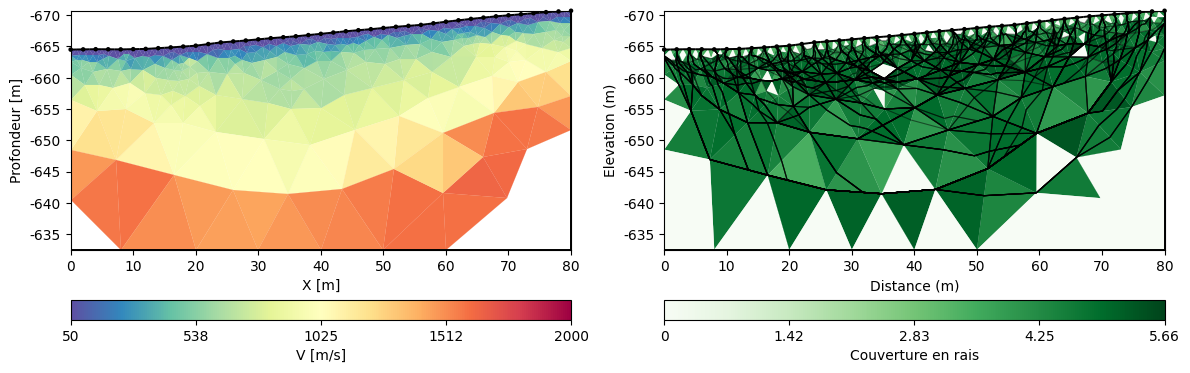

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

ax = axs[0]
pg.show(mgr.mesh, vel, coverage=mgr.standardizedCoverage(), cMin=50, cMax=2000, cMap='Spectral_r', label='V [m/s]', ax=ax)
pg.viewer.mpl.drawSensors(ax, data.sensorPositions(), diam=0.5, color="k")
ax.set_xlabel("Х [m]")
ax.set_ylabel("Profondeur [m]")

ax = axs[1]
tmpCov = mgr.coverage()
tmpCov[np.isneginf(tmpCov)] = 0
pg.show(mgr.mesh, data=tmpCov, cMin=0, ax=ax, cMap='Greens', label='Couverture en rais') #cMax=5, 
mgr.drawRayPaths(ax,color="k")
pg.viewer.mpl.drawSensors(ax, data.sensorPositions(), diam=0.5, color="k")
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Elevation (m)')

fig.tight_layout()
fig.savefig(f'figures/sismique_s_modele_rais')

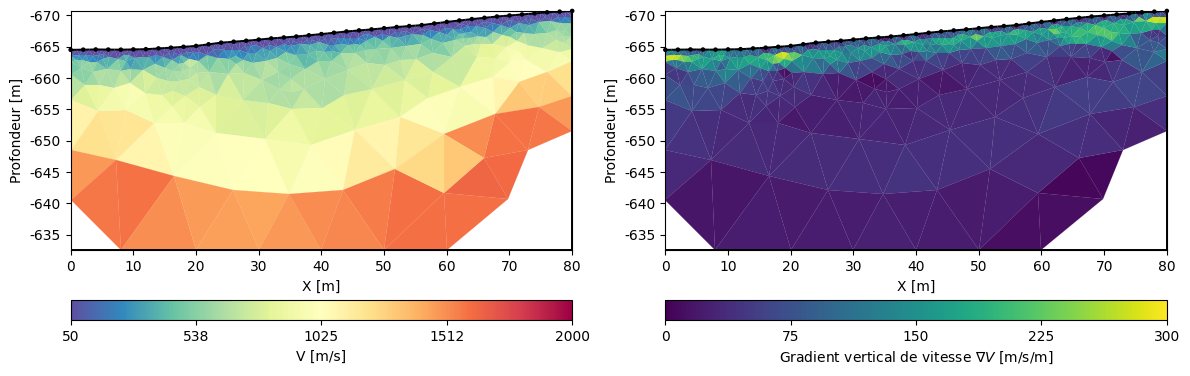

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

ax = axs[0]
pg.show(mgr.mesh, vel, coverage=mgr.standardizedCoverage(), cMin=50, cMax=2000, cMap='Spectral_r', label='V [m/s]', ax=ax)
pg.viewer.mpl.drawSensors(ax, data.sensorPositions(), diam=0.5, color="k")
ax.set_xlabel("Х [m]")
ax.set_ylabel("Profondeur [m]")

ax = axs[1]
vertGrad = pg.solver.grad(mgr.mesh, vel)
pg.show(mgr.mesh, -vertGrad[:,1], coverage=mgr.standardizedCoverage(), cMin=0, cMax=300, cMap='viridis', label='Gradient vertical de vitesse $\\nabla V$ [m/s/m]', ax=ax)
pg.viewer.mpl.drawSensors(ax, data.sensorPositions(), diam=0.5, color="k")
ax.set_xlabel("Х [m]")
ax.set_ylabel("Profondeur [m]")

fig.tight_layout()
fig.savefig(f'figures/sismique_s_modele_gradient')

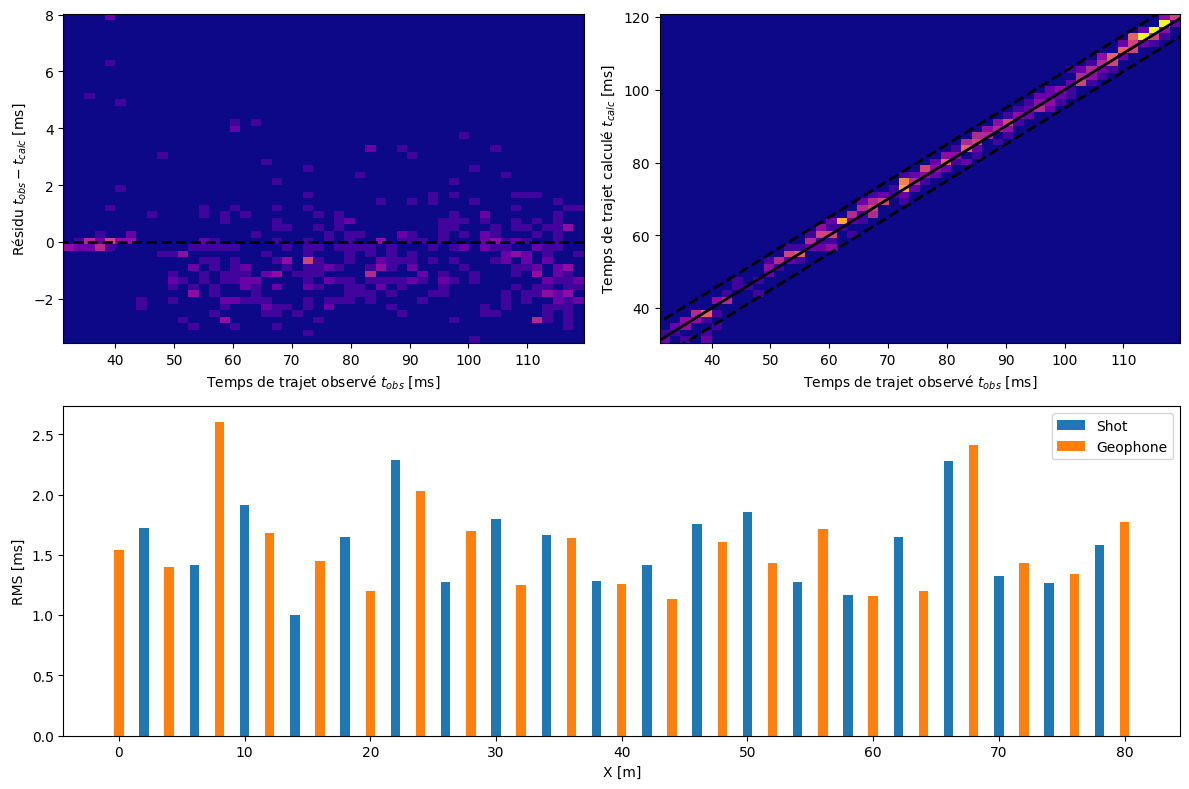

In [24]:
fig, axs = plt.subplot_mosaic("01;22", figsize=(12, 8))
axs = axs['0'], axs['1'], axs['2']

ax = axs[0]
ax.hist2d(t_data*1000, (t_data-t_model)*1000, bins=50, vmin=0,vmax=10,cmap='plasma')
ax.plot([0,200],[0,0],'k--',linewidth=2)
ax.set_xlabel('Temps de trajet observé $t_{obs}$ [ms]')
ax.set_ylabel('Résidu $t_{obs} - t_{calc}$ [ms]')

ax = axs[1]
ax.hist2d(t_data*1000, t_model*1000, bins=50, vmin=0,vmax=10,cmap='plasma')
ax.plot([0,200],[0,200],'k',linewidth=2)
ax.plot([0,200],[-5,195],'k--',linewidth=2)
ax.plot([0,200],[5,205],'k--',linewidth=2)
ax.set_xlabel('Temps de trajet observé $t_{obs}$ [ms]')
ax.set_ylabel('Temps de trajet calculé $t_{calc}$ [ms]')

ax=axs[2]
ax.bar(x[i_shots_unique], rms_shots*1000, width=.75, label='Shot')
ax.bar(x[i_geophones_unique], rms_geophones*1000, width=.75, label='Geophone')
ax.set_xlabel('X [m]')
ax.set_ylabel('RMS [ms]')
ax.legend()

fig.tight_layout()
fig.savefig(f'figures/sismique_s_misfit_modele')

08/12/24 - 19:29:51 - pyGIMLi - INFO - found 20 x values
08/12/24 - 19:29:51 - pyGIMLi - INFO - found 21 y values
08/12/24 - 19:29:51 - pyGIMLi - INFO - x vector length: 420
08/12/24 - 19:29:51 - pyGIMLi - INFO - y vector length: 420
08/12/24 - 19:29:51 - pyGIMLi - INFO - v vector length: 420
08/12/24 - 19:29:52 - pyGIMLi - INFO - found 20 x values
08/12/24 - 19:29:52 - pyGIMLi - INFO - found 21 y values
08/12/24 - 19:29:52 - pyGIMLi - INFO - x vector length: 420
08/12/24 - 19:29:52 - pyGIMLi - INFO - y vector length: 420
08/12/24 - 19:29:52 - pyGIMLi - INFO - v vector length: 420


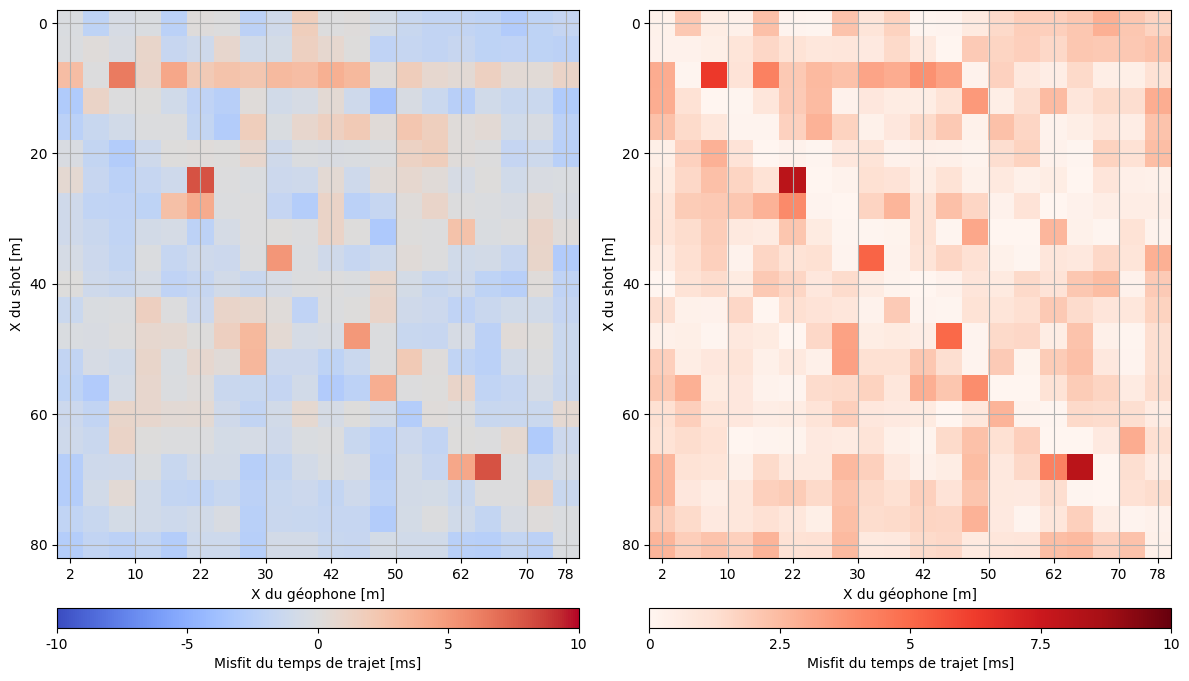

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

ax = axs[0]
ax, _ = pg.viewer.mpl.showDataContainerAsMatrix(data, x[data['s']], x[data['g']], misfit*1000,
                                                cMin=-10, cMax=10,
                                                cMap="coolwarm", full=False,
                                                label="Misfit du temps de trajet [ms]", ax=ax) # cMin=-0.0013, cMax=0.0013, 

ax.set_xlabel('X du géophone [m]')
ax.set_ylabel('X du shot [m]')

ax = axs[1]
ax, _ = pg.viewer.mpl.showDataContainerAsMatrix(data, x[data['s']], x[data['g']], np.abs(misfit)*1000,
                                                cMin=0, cMax=10,
                                                cMap="Reds", full=False,
                                                label="Misfit du temps de trajet [ms]", ax=ax) # cMin=-0.0013, cMax=0.0013, 

ax.set_xlabel('X du géophone [m]')
ax.set_ylabel('X du shot [m]')

fig.tight_layout()
fig.savefig(f'figures/sismique_s_misfit_pointage')

mgr.inv.maxIter 20


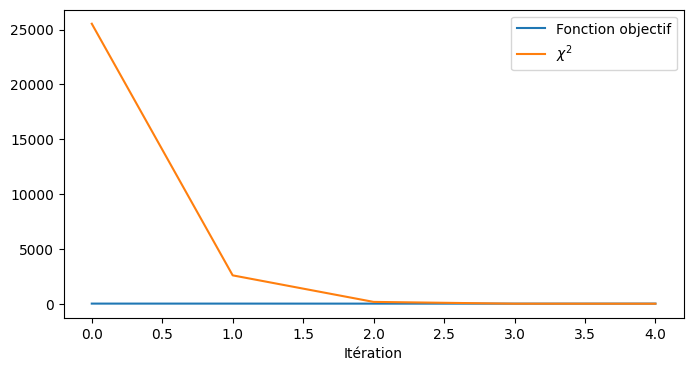

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

dPhis = []
for k, model in enumerate(mgr.inv.modelHistory[::-1]):
    # TODO compute RMS and misfit for each iteration (cost function)
    dPhi = mgr.inv.phiModel(model=model)
    dPhis.append(dPhi) # pas sur...

ax.plot(dPhis, label='Fonction objectif')
ax.plot(mgr.inv.chi2History, label='$ \chi^2 $')
ax.set_xlabel('Itération')
ax.legend()

print('mgr.inv.maxIter', mgr.inv.maxIter)

## Matrices de résolution

In [27]:
inv = mgr.createInversionFramework() # inv =
RM, RD = resolutionMatrix(inv, returnRD=True)

Text(0.5, 1.0, 'Modèle')

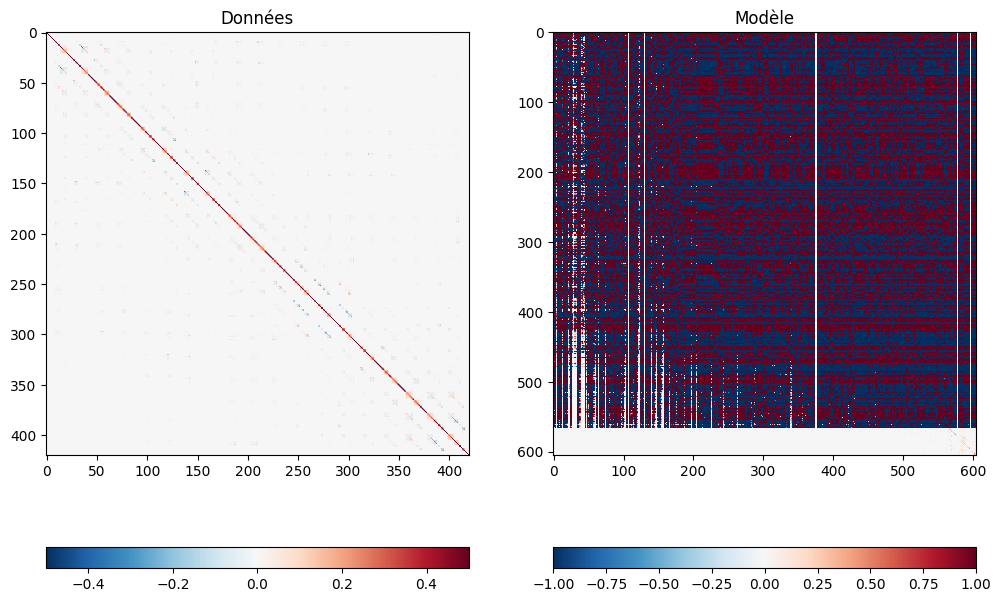

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

ax = axs[0]
im = ax.imshow(RD, cmap="RdBu_r", vmin=-0.5, vmax=.5)
cb = fig.colorbar(im, location='bottom')
ax.set_title('Données')

ax = axs[1]
im = plt.imshow(RM, cmap="RdBu_r", vmin=-1, vmax=1)
cb = fig.colorbar(im, location='bottom')
ax.set_title('Modèle')

(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>,
 <matplotlib.colorbar.Colorbar at 0x7fd15c62d5d0>)

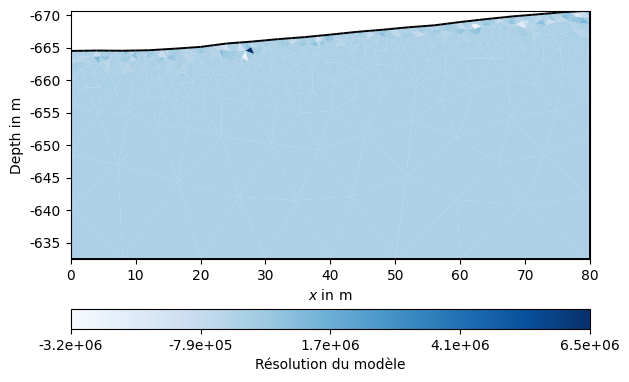

In [29]:
pg.show(mgr.paraDomain, RM[:, 0], label='Résolution du modèle', cMap='Blues', vmin=0, vmax=10)

In [30]:
## TODO
# refaire les picks
# trouver les nouveaux meilleurs paramêtres
# attention au plancher a 25m peut etre artéfact
# damier (checkboard test)